# Objectif : minimiser le max de la puissance à la racine dans une journée

### Librairies

In [1]:
import pandas as pd
from math import isnan
import numpy as np
from random import randint, uniform, sample
import matplotlib.pyplot as plt
import datetime
from time import time

### Ouverture des fichiers

In [2]:
file_name_power_limits = "data_opti/limites_puissance.csv"
file_name_consumption_info = "data_opti/info_consommation.csv"
file_name_equipments = "data_opti/equipements.csv"

# Création des df
df_power_limits = pd.read_csv(file_name_power_limits, sep = ';')
df_info_consumption = pd.read_csv(file_name_consumption_info, sep = ';', index_col = 0, decimal = ",")
df_equipments = pd.read_csv(file_name_equipments, sep = ';', index_col = 0, decimal = ",")

# Liste des noms d'équipements et des id de maison
lst_index = list(df_equipments.index.values)
lst_col = list(df_equipments.columns.values)

# Contraintes Heures creuses
dict_HC = {
    "range1" : {"begin" : "23", "end" : "7"},
    "range2" : {"begin" : '10', "end" : '16'}
}

{'range1': {'begin': '23', 'end': '7'}, 'range2': {'begin': '10', 'end': '16'}}
{'range1': {'begin': 23, 'end': 23}, 'range2': {'begin': 0, 'end': 7}, 'range3': {'begin': 10, 'end': 16}}


### Lecture fichier

In [3]:
df_power_limits.head(10)

,min_surface,max_surface,puissance
0,NaN,50.0,3
1,50.0,80.0,6
2,80.0,100.0,9
3,100.0,160.0,12
4,160.0,180.0,15
5,180.0,200.0,25
6,200.0,250.0,30
7,250.0,NaN,36


In [4]:
df_info_consumption.head(10)

,type,puissance,tps_cycle,amperage,hr_debut_hc,hr_debut_hc_nb,hr_max,sequensable
LV,Md1,1.3,1.0,6.0,0,NaN,NaN,N
LL,Md2,2.0,1.0,9.0,0,NaN,NaN,N
SL,Md3,1.0,4.0,4.0,0,NaN,NaN,N
TV,Md4,0.1,NaN,0.5,1,1.0,NaN,N
FG,Mc1,0.1,0.2,0.5,1,4.0,NaN,N
CE,Mc2,2.2,6.0,10.0,1,1.0,NaN,O
CG,Mc3,0.1,0.2,0.5,1,4.0,NaN,N
FO,Md5,1.6,NaN,12.0,1,1.0,NaN,N
PL,Md6,1.2,NaN,20.0,1,1.0,NaN,N
FG.1,Mc4,0.3,0.2,3.0,1,4.0,NaN,N


In [5]:
df_equipments.head(7)

,LV,LL,SL,TV,FG,CE,CG,FO,PL,FG.1,CE.1
A100-3-1,1,1,1,1,1,1,0,1,1,1,1
A100-3-10,1,1,1,1,1,1,0,1,1,1,0
A100-3-100,1,1,1,1,1,1,0,1,1,0,0
A100-3-101,1,1,0,1,1,1,1,1,1,0,1
A100-3-102,1,1,1,1,1,1,0,1,1,0,0
A100-3-103,1,1,1,1,1,1,1,1,1,1,0
A100-3-104,1,1,0,1,1,1,0,1,1,0,0


### Tester sur un plus petit jeu de données

In [6]:
#df_equipments_short = df_equipments[:100]
df_equipments_short = df_equipments[:]
lst_index = list(df_equipments_short.index.values)
lst_col = list(df_equipments_short.columns.values)

### Fonctions

In [7]:
# Parse le nom de chaque maison Mxxx-yy-zzz ou appartement Axxx-yy-zzz ou 
#    - Xxx : surface (m²)
#    - Yy : nb occupants
#    - Zzz : repère sur le réseau
def parse_name(lst_name_housing : str) -> dict :
    res = {'type' : [], "surface" : [], "occupants" : [], "id" : []}
    
    for str_id in lst_name_housing:
        name_housing = str_id
        if name_housing[0] == "A" : res['type'].append('appartement')
        else : res['type'].append("maison")

        # Surface m²
        name_housing = name_housing[1:]
        stop = name_housing.find("-")
        res["surface"].append(int(name_housing[:stop]))

        # Nb occupants
        name_housing = name_housing[stop + 1:]
        stop = name_housing.find("-")
        res["occupants"].append(int(name_housing[:stop]))

        # Id 
        res["id"].append(name_housing[stop + 1:])
    
    return res

In [ ]:
# quand des horaires empiètent sur les journées précédentes, on découpe en deux blocs
def modif_creneau(dict_HC : dict) -> dict :
    new_dict_HC = {}
    i = 1
    for key in dict_HC:
        start = int(dict_HC[key]["begin"])
        stop = int(dict_HC[key]["end"])
        if start > stop :
            new_dict_HC["range" + str(i)] = {"begin" : start, "end" : 23}
            i += 1
            new_dict_HC["range" + str(i)] = {"begin" : 0, "end" : stop}
        else :
            new_dict_HC["range" + str(i)] = {"begin" : start, "end" : stop}
        i += 1
    return(new_dict_HC)

In [8]:
# Définit la consommation max selon la surface en m²
def max_consumption(df_limits, surface) -> int :
    for index, row in df_limits.iterrows():
        bool1 = (row["min_surface"] < surface) if not(isnan(row["min_surface"])) else True
        bool2 = (surface <= row["max_surface"]) if not(isnan(row["max_surface"])) else True
        if bool1 and bool2 : return row["puissance"]
    return None

In [9]:
def case_hr(res, dict_hc_, df_info_consumption, df_equipment, current_equipment, tps_cycle, str_indiv, power_per_tps):
    
    # Cas où c'est un équipement qu'on doit lancer en aléatoire dans les heures creuses
    if df_info_consumption["hr_debut_hc"][current_equipment]:
        # Si le temps du cycle vaut 1 ou moins
        if tps_cycle <= 1:
            nb_repet = int(df_info_consumption["hr_debut_hc_nb"][current_equipment])
            # On récupère les horaires creuses
            lst_hc_complete = create_list_hc(dict_hc_)
            # On récupère nb_repet horaire
            lst_hc_rand = sample(lst_hc_complete, k = nb_repet) # vérifier temps cycle!!!
            
            # On vérifie que la somme pour chaque heure ne dépasse pas la somme max
            bool_index_ok = all([res[i].sum() + power_per_tps <= df_equipment['max_consumption'][str_indiv] for i in lst_hc_rand])           
            lst_index = lst_hc_rand
        # Si le temps du cycle vaut plus de 1
        else :
            # choisit un début selon les heures creuses et le temps du cycle
            index_rand_first = compute_nb_tot_hc(dict_hc_, tps_cycle)
            # On vérifie que la somme pour chaque heure ne dépasse pas la somme max
            bool_index_ok = all([res[i].sum() + power_per_tps <= df_equipment['max_consumption'][str_indiv] for i in range(index_rand_first, tps_cycle + index_rand_first)])          
            lst_index = [i for i in range(index_rand_first, tps_cycle + index_rand_first)]
    # Cas où on s'en fiche des heures creuses
    else : 
        index_rand_first = randint(0, 24 - tps_cycle)
        # On vérifie que la somme pour chaque heure ne dépasse pas la somme max
        bool_index_ok = all([res[i].sum() + power_per_tps <= df_equipment['max_consumption'][str_indiv] for i in range(index_rand_first, tps_cycle + index_rand_first)])          
        lst_index = [i for i in range(index_rand_first, tps_cycle + index_rand_first)]

    return bool_index_ok, lst_index

# choisit un début selon les heures creuses et le temps du cycle
def compute_nb_tot_hc(dict_hc_ : dict, tps_cycle) -> int :                       
    tmp = {}
    i = 0

    for key in dict_hc_:
        start, stop = int(dict_hc_[key]["begin"]), int(dict_hc_[key]["end"])
        if stop - start + 1 >= tps_cycle:  
            tmp[i] = [j for j in range(start, stop + 1)]
            i += 1
    
    randint_range = randint(0, len(tmp.keys()) - 1) if len(tmp.keys()) > 1 else 0

    index_rand_first = randint(tmp[randint_range][0], tmp[randint_range][-1] - tps_cycle)
    
    del tmp    
    return index_rand_first

compute_nb_tot_hc(new_dict_HC, 4)

# List of "heures creuses"
def create_list_hc(dict_HC : dict) -> list :
    res = []
    
    for key in dict_HC:
        for j in range(dict_HC[key]["begin"], dict_HC[key]["end"] + 1):
            res.append(j)
    
    return res

In [10]:
def generate_matrice_indiv(
    dict_hc,
    str_indiv : str, df_equipment : pd.DataFrame, df_info_consumption : pd.DataFrame, lst_col : list) -> np.array :
    
    col_name = [i for i in range(0, 24)]
    index_name, lst_tmp_info = [], []
    for i in range(len(lst_col)):
        if df_equipment[lst_col[i]][str_indiv]:
            index_name.append(lst_col[i])
            lst_tmp_info.append([df_info_consumption["tps_cycle"][lst_col[i]], df_info_consumption["puissance"][lst_col[i]]])
    lst_tmp_info = np.array(lst_tmp_info).T
    df_info_tmp = pd.DataFrame(lst_tmp_info, columns = index_name, index = ["tps_cycle", "puissance"])

    # à suppr :
    for col in list(df_info_tmp.columns.values) : 
        if isnan(df_info_tmp[col]["tps_cycle"]):
            df_info_tmp[col]["tps_cycle"] = -1
    i = 0
    
    # Initialisation du résultat  
    res = pd.DataFrame(np.zeros(shape = (len(index_name), 24)), columns = col_name, index = index_name)
    
    lst_equipment_name = list(df_info_tmp.columns.values)
    len_lst_equipment_init = len(lst_equipment_name)
    while i < len_lst_equipment_init and any([val >= 0 for val in df_info_tmp.loc["tps_cycle"]]):
        lst_equipment_name = list(df_info_tmp.columns.values)
        tps_cycle_argmax = np.argmax(df_info_tmp.loc["tps_cycle"])
        tps_cycle_max = int(np.max(df_info_tmp.loc["tps_cycle"])) 
        if float(np.max(df_info_tmp.loc["tps_cycle"])) - int(np.max(df_info_tmp.loc["tps_cycle"])) > 0:
            tps_cycle_max = tps_cycle_max + 1
        current_equipment = lst_equipment_name[tps_cycle_argmax]
        power_per_tps = df_info_tmp[current_equipment]["puissance"] / tps_cycle_max   
        ite, ite_max = 0, 1000
        bool_index_ok = False
            
        while (not(bool_index_ok) and ite < ite_max):            
            bool_index_ok, lst_index = case_hr(res, dict_hc, df_info_consumption, df_equipment, current_equipment, tps_cycle_max, str_indiv, power_per_tps)
            ite += 1
            
        if bool_index_ok:
            for j in lst_index:
                res[j][current_equipment] = power_per_tps
            df_info_tmp = df_info_tmp.drop(columns = [current_equipment])
          
        
        i += 1
        #print(any([val >= 0 for val in df_info_tmp.loc["tps_cycle"]])

    del df_info_tmp, index_name, col_name, lst_tmp_info # Libérer l'espace
    
    return res

In [11]:
# Calculer la somme de chaque puissance selon l'heure et déduire le max
def compute_objective(dict_matrixsum_by_hour : np.array) -> float :
    sum_by_hour = np.zeros(shape = (24,))
    for index in dict_index_matrix:
        sum_by_hour = np.add(sum_by_hour, np.array(dict_index_matrix[index].sum()))
    
    return (np.max(sum_by_hour))

# Affiche la somme des puissances utilisée pour chaque maison selon l'heure
def create_fig(x, y):
    plt.plot(x,y)
    plt.xlabel('Heures')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Puissance à la racine (kW)')
    plt.title("Puissance utilisée (kW) à la racine dans la journée")
    plt.show()

In [12]:
def metropolis(new_eval, best_eval, T):
    deltaF = abs(new_eval - best_eval)
    return(new_eval < best_eval or uniform(0, 1) < exp(-deltaF/T))

In [13]:
def generate_new_matrix():
    return 0

In [14]:
def generer_voisin(X):
    # prendre un
    return 0

In [15]:
# Fonction principale PASA
def PASA1(T, IterMax, Tmin, Palier, Alpha):
    # Générer pop
    # Calculer une première évaluation et la considérer comme la meilleure
    # Garder le meilleur "X" (combinaison de matrice courrante)
        
    # Boucle PASA
    iterPalier = Palier
    iter_courant = 0
    while(T > Tmin) and (iter_courant < IterMax):
        while (iterPalier > 0):
            x = 0
            # générer un nouveau X
            # Calculer le nouvel objectif
            # Si critère métropolis :  
                # enregistrer le nouveau X
                # calculer le nouvel y
        
        
        T = T*Alpha # faire diminuer T - refroidissement
        iter_courant += 1 # incrémenter nb itération
        iterPalier = Palier

### Paramètres du recuit

In [16]:
T0 = 150  # temperature initiale
Tmin = 1e-3 # temperature finale
tau = 1e4 # constante pour la décroissance de temperature
Alpha = 0.9 # constante pour la décroissance géométrique
Palier = 7 # nombre d'itérations sur un palier de température
IterMax = 15000 # nombre max d'itérations de l'algorithme

### Initialisation

In [ ]:
# Avant modif heure creuse
print(dict_HC)
# Après modif heure creuse
new_dict_HC = modif_creneau(dict_HC)
print(new_dict_HC)

In [17]:
dict_house = parse_name(lst_index)
dict_house["max_consumption"] = [max_consumption(df_power_limits, surface_indiv) for surface_indiv in dict_house['surface']]

for key in dict_house.keys():
    if key not in list(df_equipments_short.columns.values):
        df_equipments_short.insert(loc=len(df_equipments_short.columns),
              column=key,
              value=np.array(dict_house[key]))
    else : df_equipments_short[key] = np.array(dict_house[key])

df_equipments_short.head(10)

,LV,LL,SL,TV,FG,CE,CG,FO,PL,FG.1,CE.1,type,surface,occupants,id,max_consumption
A100-3-1,1,1,1,1,1,1,0,1,1,1,1,appartement,100,3,1,9.0
A100-3-10,1,1,1,1,1,1,0,1,1,1,0,appartement,100,3,10,9.0
A100-3-100,1,1,1,1,1,1,0,1,1,0,0,appartement,100,3,100,9.0
A100-3-101,1,1,0,1,1,1,1,1,1,0,1,appartement,100,3,101,9.0
A100-3-102,1,1,1,1,1,1,0,1,1,0,0,appartement,100,3,102,9.0
A100-3-103,1,1,1,1,1,1,1,1,1,1,0,appartement,100,3,103,9.0
A100-3-104,1,1,0,1,1,1,0,1,1,0,0,appartement,100,3,104,9.0
A100-3-105,1,1,0,1,1,1,1,1,1,0,0,appartement,100,3,105,9.0
A100-3-106,1,1,0,1,1,1,0,1,1,1,0,appartement,100,3,106,9.0
A100-3-107,1,1,1,1,1,1,1,1,1,1,0,appartement,100,3,107,9.0


In [18]:
# Générer un premier dictionnaire de matrice et déterminer la somme de chaque
dict_index_matrix = {}
sum_by_hour =  np.zeros(shape = (24,))

i = 0
start_time = time()
for index in lst_index:
    if (i % 1000 == 0): print("--- %s seconds ---" % (time() - start_time))
    dict_index_matrix[index] = generate_matrice_indiv(new_dict_HC, index, df_equipments_short, df_info_consumption, lst_col)
    sum_by_hour = np.add(sum_by_hour, np.array(dict_index_matrix[index].sum()))
    i += 1
print("---FINAL %s seconds ---" % (time() - start_time))

pd.set_option('display.max_column', None)
display(dict_index_matrix["A100-3-1"])
display(dict_index_matrix["A100-3-124"])

#print(dict_index_matrix[list(dict_index_matrix.keys)[0]])
best_evaluation = compute_objective(sum_by_hour)

--- 7.033348083496094e-05 seconds ---
--- 10.364479303359985 seconds ---
--- 20.04617691040039 seconds ---
--- 30.618765354156494 seconds ---
--- 36.2947952747345 seconds ---
--- 42.32840180397034 seconds ---
--- 49.399516344070435 seconds ---
--- 57.81914234161377 seconds ---
--- 67.74643921852112 seconds ---
--- 78.3448555469513 seconds ---
--- 88.98198771476746 seconds ---
--- 100.49901795387268 seconds ---
--- 111.73300790786743 seconds ---
--- 123.02008438110352 seconds ---
--- 133.75513982772827 seconds ---
--- 144.98672008514404 seconds ---
--- 154.68110632896423 seconds ---
--- 163.6271002292633 seconds ---
--- 172.25982022285461 seconds ---
--- 180.82001900672913 seconds ---
--- 189.74187183380127 seconds ---
---FINAL 197.07687783241272 seconds ---


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
LV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,1.30,0.00,0.00,0.0
LL,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
SL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.0
TV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
FG,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.1
CE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
FO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
PL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
FG.1,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.300000,0.000000,0.300000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
CE.1,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
LV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
TV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FG,0.0,0.1,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FG.1,0.3,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3


In [19]:
display(dict_index_matrix["A100-3-1"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
LV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,1.30,0.00,0.00,0.0
LL,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
SL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.0
TV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
FG,0.1,0.1,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.1
CE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
FO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
PL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
FG.1,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.300000,0.000000,0.300000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0
CE.1,0.0,0.5,0.5,0.5,0.5,0.5,0.5,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0


In [20]:
display(dict_index_matrix["A100-3-137"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
LV,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1.3,0.0,0.0,0.0,0.0,0.0
LL,0.0,0.0,0.0,2.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SL,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TV,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FG,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.100000,0.000000,0.100000,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1
CE,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.366667,0.366667,0.366667,0.366667,0.366667,0.366667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FO,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PL,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CE.1,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


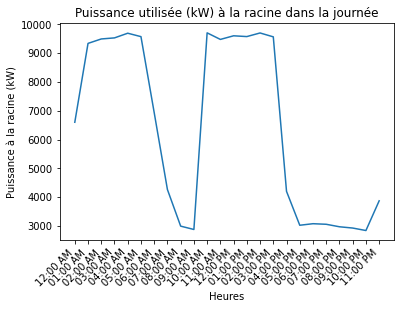

In [21]:
# Générer un premier dictionnaire de matrice et déterminer la somme de chaque
y = list(sum_by_hour)
x = [datetime.time(i).strftime("%I:00 %p") for i in range(0, 24)]

create_fig(x, y)  

In [22]:
print(best_evaluation)

9706.666666667492


### Fonction principale PASA

idée : 
- premier algo PASA "bête" : optimiser un param d'une maison
- deuxième algo PASA : optimiser un param de chaque noeud 
- tester algo multi agent NSGA

In [23]:
# utiliser PASA
# Afficher le premier et le dernier graphique ?